1. Data Loading and Exploration

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('diabetes.csv')

print("First rows of the dataset:")
print(data.head())
print("\nSummary statistics:")
print(data.describe())
print("\nInfo:")
print(data.info())

First rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Summary statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972

 2. Data Exploration (Histograms)

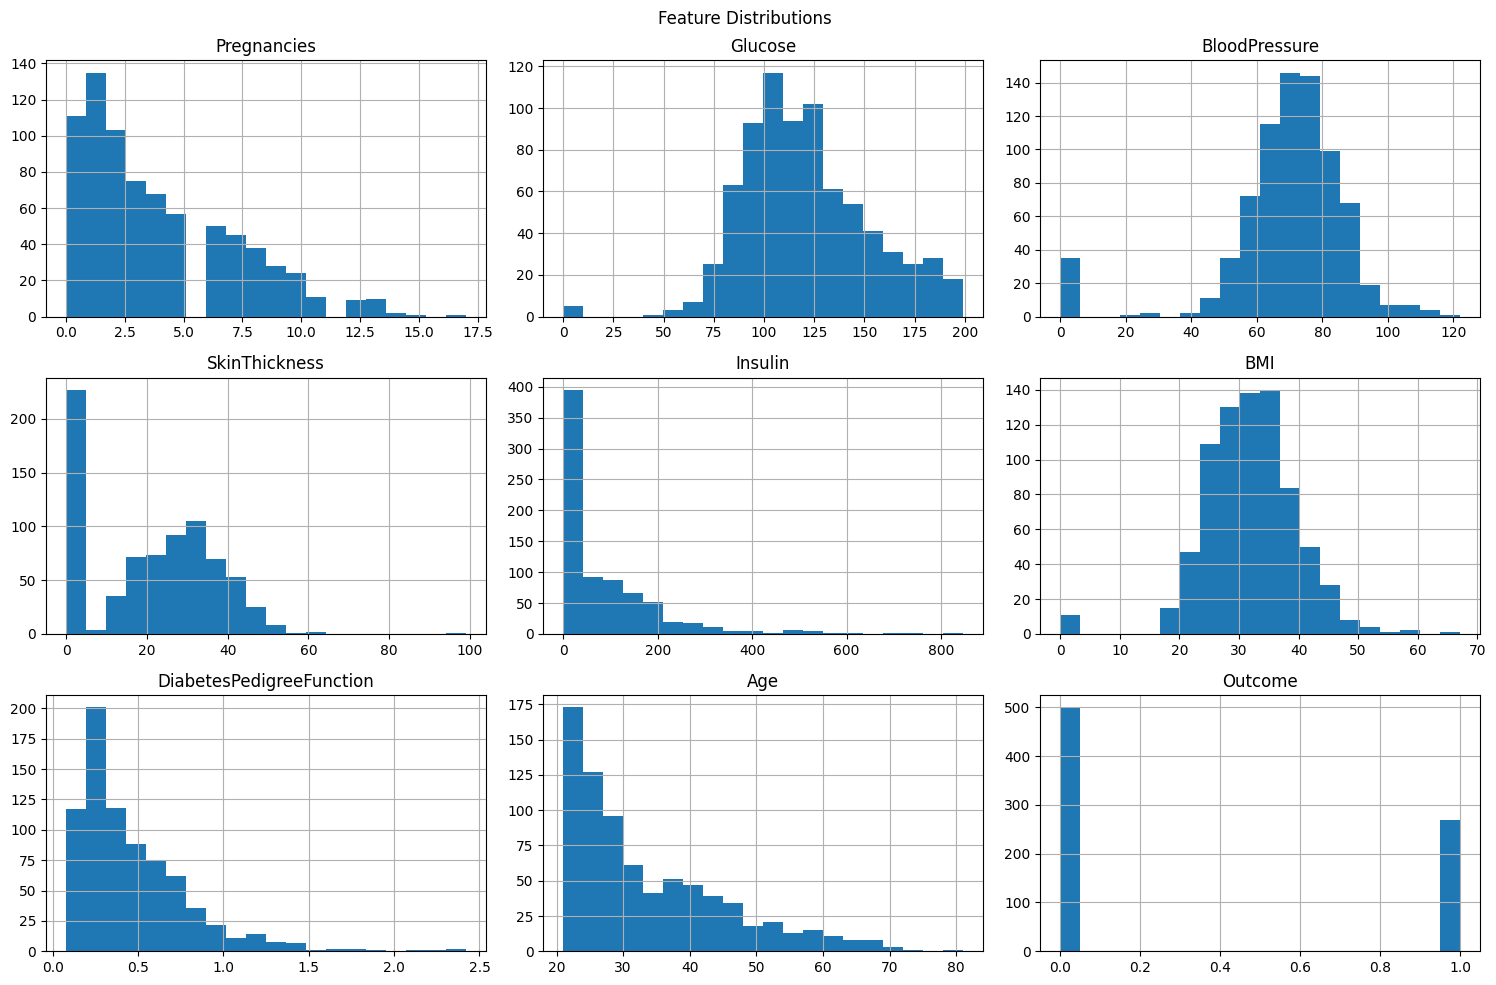

In [74]:
data.hist(bins=20, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

3. Missing and Invalid Values

In [75]:
invalid_zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_counts = (data[invalid_zero_features] == 0).sum()
print("\nNumber of zeros in each feature (to be treated as missing):")
print(zero_counts)


Number of zeros in each feature (to be treated as missing):
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


zero values per feature

<ipython-input-76-e6c8dcc6ea1e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_zero, x='Feature', y='Zero Percent', palette='Set1')


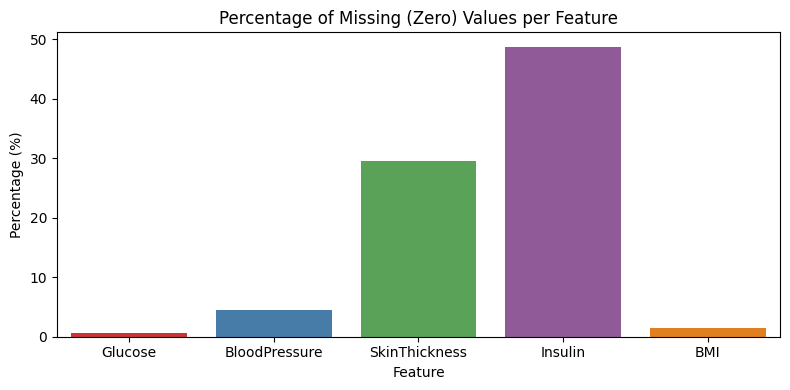

In [76]:
missing_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

zero_counts = data[missing_features].eq(0).sum()
zero_percent = (zero_counts / len(data)) * 100

df_zero = zero_percent.reset_index()
df_zero.columns = ['Feature', 'Zero Percent']

plt.figure(figsize=(8, 4))
sns.barplot(data=df_zero, x='Feature', y='Zero Percent', palette='Set1')
plt.title('Percentage of Missing (Zero) Values per Feature')
plt.ylabel('Percentage (%)')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

4. Data Cleaning

In [77]:
for col in invalid_zero_features:
    median = data.loc[data[col] != 0, col].median()
    data[col] = data[col].replace(0, median)

5. Feature Scaling

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = data.columns.drop('Outcome')
data[features] = scaler.fit_transform(data[features])

6. Class Balance


Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


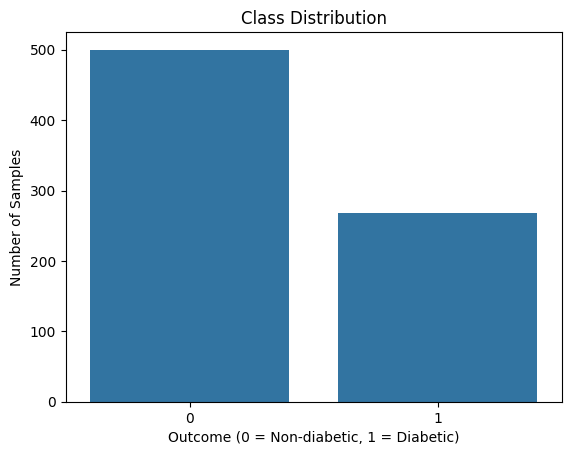

In [79]:
class_counts = data['Outcome'].value_counts()
print("\nClass distribution:")
print(class_counts)

sns.countplot(x='Outcome', data=data)
plt.title('Class Distribution')
plt.xlabel('Outcome (0 = Non-diabetic, 1 = Diabetic)')
plt.ylabel('Number of Samples')
plt.show()

7. Data Splitting

In [80]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
print(f"\nTrain: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (460, 8), Validation: (154, 8), Test: (154, 8)


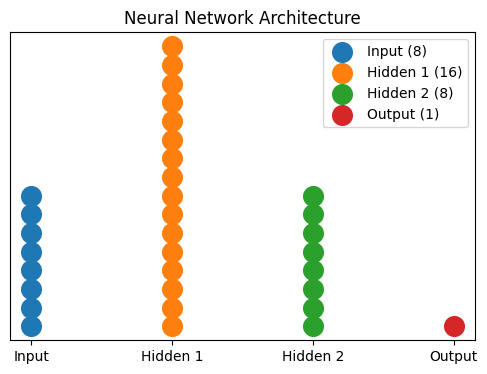

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
layer_sizes = [8, 16, 8, 1]
layer_names = ['Input', 'Hidden 1', 'Hidden 2', 'Output']

for i, (size, name) in enumerate(zip(layer_sizes, layer_names)):
    ax.scatter([i]*size, range(size), s=200, label=f'{name} ({size})')
ax.set_xticks(range(len(layer_sizes)))
ax.set_xticklabels(layer_names)
ax.set_yticks([])
ax.set_title('Neural Network Architecture')
ax.legend()
plt.show()

8. Neural Network Architecture (MLP) & ADAM

In [82]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

class AdamOptimizer:
    def __init__(self, layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = [np.zeros((layer_sizes[i], layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        self.v_w = [np.zeros((layer_sizes[i], layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        self.m_b = [np.zeros((1, layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        self.v_b = [np.zeros((1, layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        self.t += 1
        new_weights = []
        new_biases = []
        for i in range(len(weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            w_update = self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            new_weights.append(weights[i] - w_update)
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)
            b_update = self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
            new_biases.append(biases[i] - b_update)
        return new_weights, new_biases

class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, optimizer=None, l2_lambda=0.0):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i]))
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):
        activations = [X]
        zs = []
        a = X
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            zs.append(z)
            a = relu(z)
            activations.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        zs.append(z)
        a = sigmoid(z)
        activations.append(a)
        return activations, zs

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        eps = 1e-8
        loss = -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

        l2_term = 0.0
        if self.l2_lambda > 0:
            l2_term = (self.l2_lambda / (2 * m)) * sum(np.sum(w ** 2) for w in self.weights)
        return loss + l2_term

    def backward(self, activations, zs, y_true):
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)
        m = y_true.shape[0]

        delta = activations[-1] - y_true
        grads_w[-1] = np.dot(activations[-2].T, delta) / m
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True) / m

        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[l+1].T) * relu_derivative(zs[l])
            grads_w[l] = np.dot(activations[l].T, delta) / m
            grads_b[l] = np.sum(delta, axis=0, keepdims=True) / m

        if self.l2_lambda > 0:
            for i in range(len(grads_w)):
                grads_w[i] += (self.l2_lambda / m) * self.weights[i]
        return grads_w, grads_b

    def update_params(self, grads_w, grads_b):
        if self.optimizer is None:
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grads_w[i]
                self.biases[i] -= self.learning_rate * grads_b[i]
        else:
            self.weights, self.biases = self.optimizer.update(self.weights, self.biases, grads_w, grads_b)

    def predict(self, X):
        a = X
        for i in range(len(self.weights) - 1):
            a = relu(np.dot(a, self.weights[i]) + self.biases[i])
        a = sigmoid(np.dot(a, self.weights[-1]) + self.biases[-1])
        return (a > 0.5).astype(int)

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        for epoch in range(epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[idx], y_train[idx]
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                activations, zs = self.forward(X_batch)
                grads_w, grads_b = self.backward(activations, zs, y_batch)
                self.update_params(grads_w, grads_b)
            y_train_pred = self.forward(X_train)[0][-1]
            y_val_pred = self.forward(X_val)[0][-1]
            train_loss = self.compute_loss(y_train, y_train_pred)
            val_loss = self.compute_loss(y_val, y_val_pred)
            train_acc = np.mean((y_train_pred > 0.5) == y_train)
            val_acc = np.mean((y_val_pred > 0.5) == y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

9. Training Procedure

In [83]:
nn = NeuralNetwork(layer_sizes=[8, 16, 8, 1], learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

Epoch 0: Train Loss=0.7529, Val Loss=0.7846, Train Acc=0.5761, Val Acc=0.5325
Epoch 10: Train Loss=0.5968, Val Loss=0.6073, Train Acc=0.6783, Val Acc=0.6753
Epoch 20: Train Loss=0.5418, Val Loss=0.5365, Train Acc=0.7130, Val Acc=0.7403
Epoch 30: Train Loss=0.5102, Val Loss=0.4982, Train Acc=0.7413, Val Acc=0.7403
Epoch 40: Train Loss=0.4898, Val Loss=0.4773, Train Acc=0.7630, Val Acc=0.7597
Epoch 50: Train Loss=0.4774, Val Loss=0.4683, Train Acc=0.7674, Val Acc=0.7468
Epoch 60: Train Loss=0.4686, Val Loss=0.4623, Train Acc=0.7674, Val Acc=0.7662
Epoch 70: Train Loss=0.4617, Val Loss=0.4582, Train Acc=0.7739, Val Acc=0.7597
Epoch 80: Train Loss=0.4564, Val Loss=0.4555, Train Acc=0.7826, Val Acc=0.7597
Epoch 90: Train Loss=0.4516, Val Loss=0.4531, Train Acc=0.7870, Val Acc=0.7597


10. Evaluation on Test Set

In [84]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = nn.predict(X_test)
print("\nTest set classification report:")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


Test set classification report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       100
           1       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion matrix:
 [[81 19]
 [26 28]]


11. Plotting Loss and Accuracy Curves

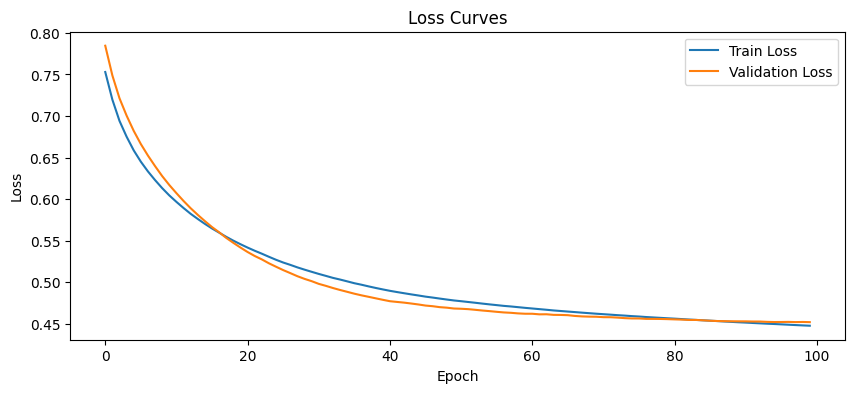

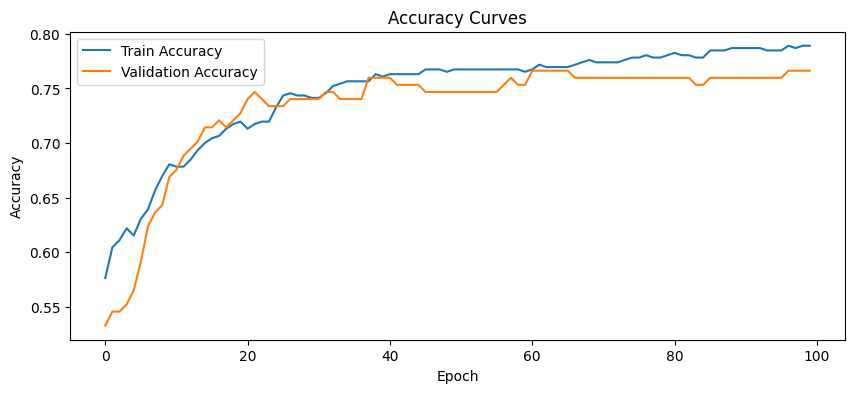

In [85]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

Test Set Performance

              precision    recall  f1-score   support

Non-diabetic       0.76      0.81      0.78       100
    Diabetic       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion matrix:
 [[81 19]
 [26 28]]


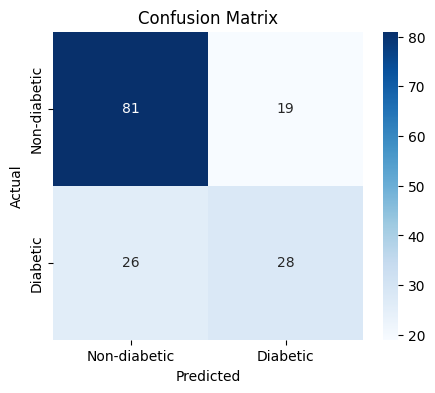

In [87]:
y_test_pred = nn.predict(X_test)

report = classification_report(y_test, y_test_pred, target_names=['Non-diabetic', 'Diabetic'])
print(report)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-diabetic', 'Diabetic'], yticklabels=['Non-diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Loss curve

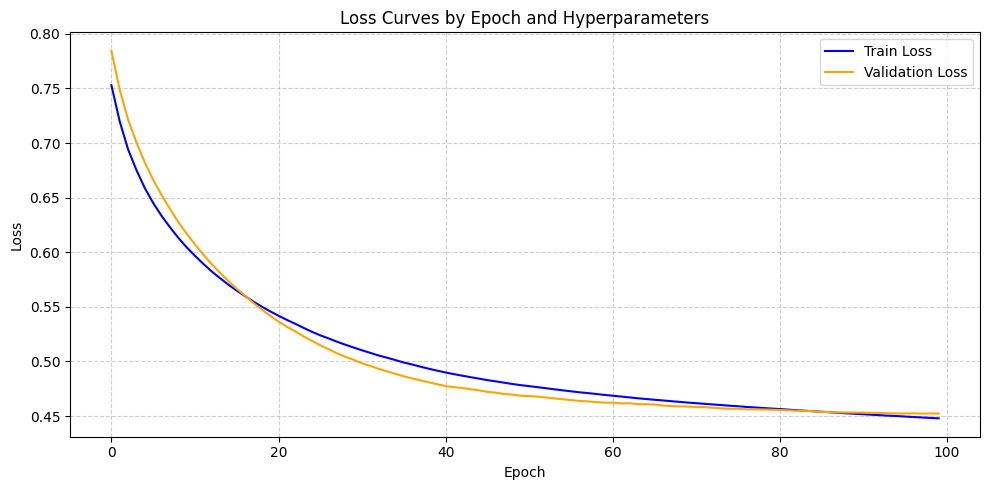

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves by Epoch and Hyperparameters')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Class Imbalance

In [89]:
class_counts = data['Outcome'].value_counts()
total = class_counts.sum()
for cls, count in class_counts.items():
    percent = 100 * count / total
    label = "Diabetic" if cls == 1 else "Non-diabetic"
    print(f"{label}: {count} samples ({percent:.1f}%)")

Non-diabetic: 500 samples (65.1%)
Diabetic: 268 samples (34.9%)


Adam Optimizer train & metrics

In [90]:
adam_optimizer = AdamOptimizer(layer_sizes=[8, 16, 8, 1], learning_rate=0.001)
nn_adam = NeuralNetwork(layer_sizes=[8, 16, 8, 1], optimizer=adam_optimizer)
train_losses_adam, val_losses_adam, train_accuracies_adam, val_accuracies_adam = nn_adam.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

y_test_pred_adam = nn_adam.predict(X_test)
print("\n[Adam] Test set classification report:")
print(classification_report(y_test, y_test_pred_adam))
print("[Adam] Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_adam))

Epoch 0: Train Loss=0.7355, Val Loss=0.7637, Train Acc=0.6087, Val Acc=0.5584
Epoch 10: Train Loss=0.5157, Val Loss=0.5088, Train Acc=0.7500, Val Acc=0.7532
Epoch 20: Train Loss=0.4667, Val Loss=0.4597, Train Acc=0.7891, Val Acc=0.7597
Epoch 30: Train Loss=0.4461, Val Loss=0.4520, Train Acc=0.8000, Val Acc=0.7662
Epoch 40: Train Loss=0.4331, Val Loss=0.4484, Train Acc=0.8109, Val Acc=0.7662
Epoch 50: Train Loss=0.4233, Val Loss=0.4492, Train Acc=0.8130, Val Acc=0.7597
Epoch 60: Train Loss=0.4148, Val Loss=0.4499, Train Acc=0.8174, Val Acc=0.7662
Epoch 70: Train Loss=0.4063, Val Loss=0.4505, Train Acc=0.8217, Val Acc=0.7597
Epoch 80: Train Loss=0.3979, Val Loss=0.4506, Train Acc=0.8304, Val Acc=0.7597
Epoch 90: Train Loss=0.3912, Val Loss=0.4524, Train Acc=0.8370, Val Acc=0.7597

[Adam] Test set classification report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    acc

Loss Curves: Adam vs. SGD

Epoch 0: Train Loss=0.7529, Val Loss=0.7846, Train Acc=0.5761, Val Acc=0.5325
Epoch 10: Train Loss=0.5968, Val Loss=0.6073, Train Acc=0.6783, Val Acc=0.6753
Epoch 20: Train Loss=0.5418, Val Loss=0.5365, Train Acc=0.7130, Val Acc=0.7403
Epoch 30: Train Loss=0.5102, Val Loss=0.4982, Train Acc=0.7413, Val Acc=0.7403
Epoch 40: Train Loss=0.4898, Val Loss=0.4773, Train Acc=0.7630, Val Acc=0.7597
Epoch 50: Train Loss=0.4774, Val Loss=0.4683, Train Acc=0.7674, Val Acc=0.7468
Epoch 60: Train Loss=0.4686, Val Loss=0.4623, Train Acc=0.7674, Val Acc=0.7662
Epoch 70: Train Loss=0.4617, Val Loss=0.4582, Train Acc=0.7739, Val Acc=0.7597
Epoch 80: Train Loss=0.4564, Val Loss=0.4555, Train Acc=0.7826, Val Acc=0.7597
Epoch 90: Train Loss=0.4516, Val Loss=0.4531, Train Acc=0.7870, Val Acc=0.7597
Epoch 0: Train Loss=0.7355, Val Loss=0.7637, Train Acc=0.6087, Val Acc=0.5584
Epoch 10: Train Loss=0.5157, Val Loss=0.5088, Train Acc=0.7500, Val Acc=0.7532
Epoch 20: Train Loss=0.4667, Val Loss=0.4597, Train Ac

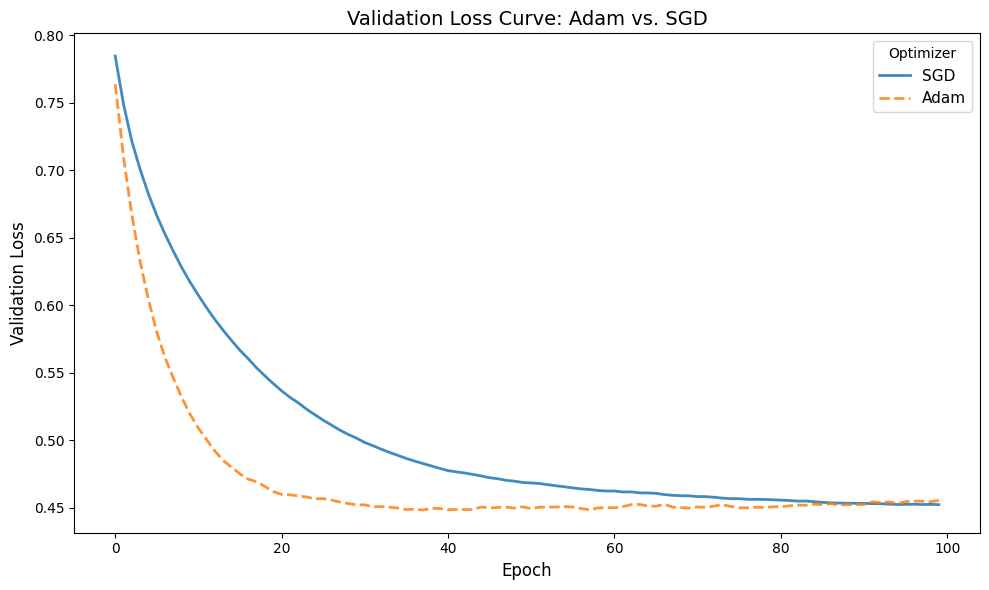

In [92]:
architecture = [8, 16, 8, 1]

optimizers = {
    'SGD': None,
    'Adam': lambda arch: AdamOptimizer(layer_sizes=arch, learning_rate=0.001)
}

plt.figure(figsize=(10, 6))

for opt_name, opt_fn in optimizers.items():
    optimizer_instance = opt_fn(architecture) if opt_fn is not None else None
    learning_rate = 0.01 if opt_name == 'SGD' else 0.001
    nn = NeuralNetwork(layer_sizes=architecture, learning_rate=learning_rate, optimizer=optimizer_instance)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
        X_train, y_train, X_val, y_val, epochs=100, batch_size=32
    )
    linestyle = '-' if opt_name == 'SGD' else '--'
    plt.plot(val_losses, linestyle, label=opt_name, linewidth=2, alpha=0.85)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Validation Loss Curve: Adam vs. SGD', fontsize=14)
plt.legend(title='Optimizer', fontsize=11)
plt.tight_layout()
plt.show()

In [93]:
nn_l2 = NeuralNetwork(layer_sizes=[8, 16, 8, 1], learning_rate=0.01, l2_lambda=0.01)
train_losses_l2, val_losses_l2, train_accuracies_l2, val_accuracies_l2 = nn_l2.train(
    X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)

Epoch 0: Train Loss=0.7535, Val Loss=0.7861, Train Acc=0.5761, Val Acc=0.5325
Epoch 10: Train Loss=0.5973, Val Loss=0.6088, Train Acc=0.6783, Val Acc=0.6753
Epoch 20: Train Loss=0.5425, Val Loss=0.5382, Train Acc=0.7130, Val Acc=0.7403
Epoch 30: Train Loss=0.5108, Val Loss=0.4998, Train Acc=0.7413, Val Acc=0.7403
Epoch 40: Train Loss=0.4905, Val Loss=0.4789, Train Acc=0.7630, Val Acc=0.7597
Epoch 50: Train Loss=0.4780, Val Loss=0.4698, Train Acc=0.7674, Val Acc=0.7468
Epoch 60: Train Loss=0.4692, Val Loss=0.4637, Train Acc=0.7652, Val Acc=0.7662
Epoch 70: Train Loss=0.4623, Val Loss=0.4595, Train Acc=0.7739, Val Acc=0.7597
Epoch 80: Train Loss=0.4570, Val Loss=0.4569, Train Acc=0.7804, Val Acc=0.7597
Epoch 90: Train Loss=0.4522, Val Loss=0.4545, Train Acc=0.7848, Val Acc=0.7597


Epoch 0: Train Loss=0.7376, Val Loss=0.7187, Train Acc=0.5783, Val Acc=0.6104
Epoch 10: Train Loss=0.5978, Val Loss=0.5639, Train Acc=0.6609, Val Acc=0.6623
Epoch 20: Train Loss=0.5479, Val Loss=0.5094, Train Acc=0.6804, Val Acc=0.6753
Epoch 30: Train Loss=0.5216, Val Loss=0.4828, Train Acc=0.7022, Val Acc=0.7468
Epoch 40: Train Loss=0.5049, Val Loss=0.4671, Train Acc=0.7304, Val Acc=0.7727
Epoch 50: Train Loss=0.4932, Val Loss=0.4569, Train Acc=0.7457, Val Acc=0.7857
Epoch 60: Train Loss=0.4843, Val Loss=0.4504, Train Acc=0.7587, Val Acc=0.7922
Epoch 70: Train Loss=0.4771, Val Loss=0.4465, Train Acc=0.7761, Val Acc=0.7922
Epoch 80: Train Loss=0.4714, Val Loss=0.4438, Train Acc=0.7783, Val Acc=0.7857
Epoch 90: Train Loss=0.4666, Val Loss=0.4416, Train Acc=0.7848, Val Acc=0.7922
Epoch 0: Train Loss=0.7379, Val Loss=0.7197, Train Acc=0.5783, Val Acc=0.6104
Epoch 10: Train Loss=0.5981, Val Loss=0.5649, Train Acc=0.6609, Val Acc=0.6623
Epoch 20: Train Loss=0.5482, Val Loss=0.5104, Train Ac

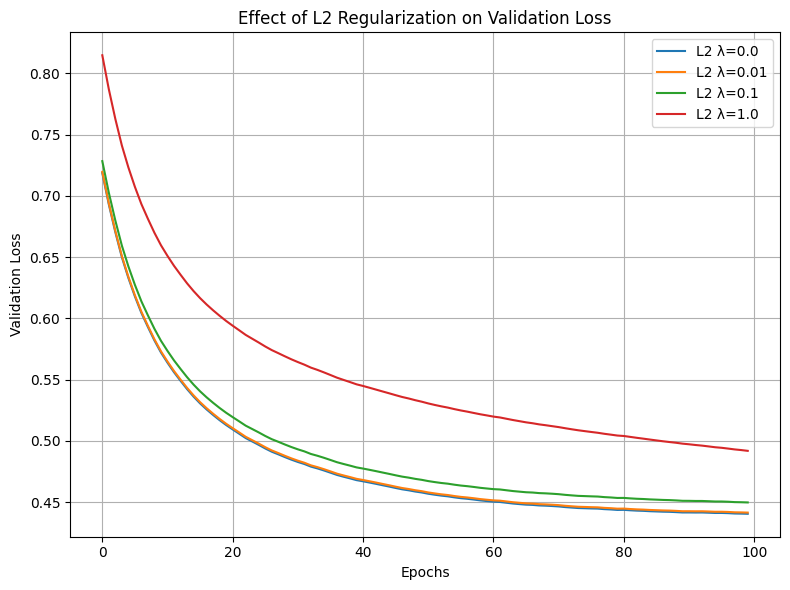

In [94]:
l2_lambdas = [0.0, 0.01, 0.1, 1.0]
val_losses_dict = {}

for l2 in l2_lambdas:
    nn = NeuralNetwork(
        layer_sizes=[X_train.shape[1], 16, 1],
        learning_rate=0.01,
        optimizer=None,
        l2_lambda=l2
    )
    result = nn.train(X_train, y_train, X_val, y_val, epochs=100)
    val_losses = result[1]
    val_losses_dict[l2] = val_losses

plt.figure(figsize=(8, 6))
for l2, losses in val_losses_dict.items():
    plt.plot(losses, label=f"L2 λ={l2}")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Alternative Architectures

Epoch 0: Train Loss=0.9103, Val Loss=0.8874, Train Acc=0.4304, Val Acc=0.4286
Epoch 10: Train Loss=0.5721, Val Loss=0.5410, Train Acc=0.6696, Val Acc=0.7273
Epoch 20: Train Loss=0.5287, Val Loss=0.4994, Train Acc=0.7196, Val Acc=0.7338
Epoch 30: Train Loss=0.5126, Val Loss=0.4840, Train Acc=0.7304, Val Acc=0.7338
Epoch 40: Train Loss=0.5022, Val Loss=0.4744, Train Acc=0.7304, Val Acc=0.7468
Epoch 50: Train Loss=0.4934, Val Loss=0.4665, Train Acc=0.7370, Val Acc=0.7727
Epoch 60: Train Loss=0.4854, Val Loss=0.4600, Train Acc=0.7478, Val Acc=0.7727
Epoch 70: Train Loss=0.4786, Val Loss=0.4550, Train Acc=0.7696, Val Acc=0.7662
Epoch 80: Train Loss=0.4730, Val Loss=0.4504, Train Acc=0.7761, Val Acc=0.7662
Epoch 90: Train Loss=0.4688, Val Loss=0.4470, Train Acc=0.7761, Val Acc=0.7662
Epoch 0: Train Loss=0.9573, Val Loss=0.9354, Train Acc=0.4000, Val Acc=0.3961
Epoch 10: Train Loss=0.6233, Val Loss=0.5879, Train Acc=0.6391, Val Acc=0.6753
Epoch 20: Train Loss=0.5269, Val Loss=0.4911, Train Ac

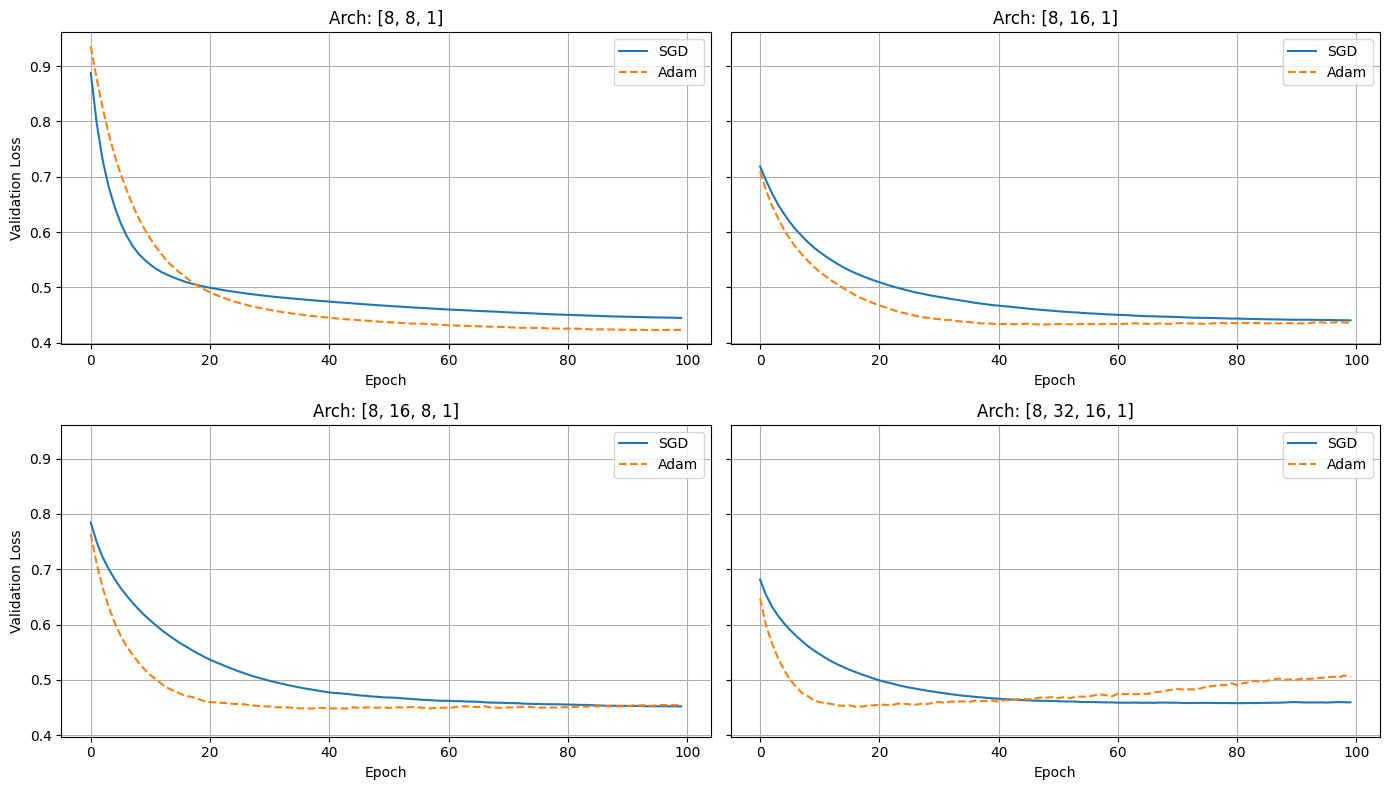

In [95]:
architectures = [
    [8, 8, 1],
    [8, 16, 1],
    [8, 16, 8, 1],
    [8, 32, 16, 1]
]

optimizers = {
    'SGD': None,
    'Adam': lambda arch: AdamOptimizer(layer_sizes=arch, learning_rate=0.001)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

for idx, arch in enumerate(architectures):
    ax = axes[idx]
    for opt_name, opt_fn in optimizers.items():
        optimizer_instance = opt_fn(arch) if opt_fn is not None else None
        learning_rate = 0.01 if opt_name == 'SGD' else 0.001
        nn = NeuralNetwork(layer_sizes=arch, learning_rate=learning_rate, optimizer=optimizer_instance)
        train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
            X_train, y_train, X_val, y_val, epochs=100, batch_size=32
        )
        ax.plot(val_losses, label=f'{opt_name}', linestyle='-' if opt_name == 'SGD' else '--')
    ax.set_title(f'Arch: {arch}')
    ax.set_xlabel('Epoch')
    if idx % 2 == 0:
        ax.set_ylabel('Validation Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig("loss_curves.png")
plt.show()